In [1]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from utils.build_zuko_guide import build_zuko_guide, ZukoGuide
from utils.functional_factor_added import FunctionalFactorAdded
from utils.module_requires_grad import module_requires_grad_
from utils.tabi_reparametrized_functional import TABIReparametrizedFunctionalOfPrior
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns
from chirho.robust.ops import influence_fn
# from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator
from chirho.robust.internals.full_linearize_from_left import full_linearize_from_left
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

tnsr = torch.tensor

# Settings
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)


# seed = randint(0, int(1e6))
# print(seed)

seed = 2805018

pyro.set_rng_seed(seed)

# Simple Model

In [2]:
from collections import OrderedDict
class DebugInstanceDict(OrderedDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __setitem__(self, key, value):
        if key in ["loc", "scale_tril"]:
            if not isinstance(value, torch.nn.Parameter):
                print(f"WARNING: setting non parameter for argument {key}")
                print(f"OLD VALUE: {self[key]}")
                print(f"NEW VALUE: {value}")
            elif isinstance(value, torch.nn.Parameter):
                print(f"Setting parameter for argument {key}")
        return super().__setitem__(key, value)

In [3]:
# Sample from an MVN by sampling two normals sequentially.
class ChainedNormals(torch.nn.Module):
    def __init__(self, loc, scale_tril, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._parameters = DebugInstanceDict(**self._parameters)
        
        
        
        # Register these as parameters so that the EIF can be computed using their gradients.
        self.loc = torch.nn.Parameter(loc.detach().clone())
        self.scale_tril =  torch.nn.Parameter(scale_tril.detach().clone())
    
    @staticmethod
    def _transform_to_sequential_normal_parameters(loc, scale_tril):
        # Thanks ChatGPT
        
        cov = scale_tril @ scale_tril.t()
        
        loc1 = loc[0]
        std1 = torch.sqrt(cov[0, 0])
        
        loc2_base = loc[1]
        sigma_21 = cov[1, 0]
        sigma_11 = cov[0, 0]
        sigma_22 = cov[1, 1]
        
        # Precompute part of the conditional mean expression
        conditional_loc2_base = loc2_base - (sigma_21 / sigma_11) * loc1
        conditional_std2 = torch.sqrt(sigma_22 - (sigma_21**2 / sigma_11))
        
        return loc1, std1, conditional_loc2_base, sigma_21, sigma_11, conditional_std2
    
    def forward(self):
        
        loc1, std1, conditional_loc2_base, sigma_21, sigma_11, conditional_std2 = \
            self._transform_to_sequential_normal_parameters(self.loc, self.scale_tril)
        
        # Sample from the first normal distribution
        z1 = pyro.sample("z1", dist.Normal(
            loc=loc1,
            scale=std1
        ))
        
        # Compute the conditional mean using the sampled z1
        conditional_loc2 = conditional_loc2_base + (sigma_21 / sigma_11) * z1
        
        # Sample from the second normal distribution with the conditional mean
        z2 = pyro.sample("z2", dist.Normal(
            loc=conditional_loc2,
            scale=conditional_std2
        ))
        
        return z1, z2

In [4]:
prior = ChainedNormals(
    loc=torch.tensor([0., 0.]),
    scale_tril=torch.linalg.cholesky(torch.tensor([
        [5.0, -0.0],
        [-0.0, 5.0]
    ]))
)

Setting parameter for argument loc
Setting parameter for argument scale_tril


(-6.0, 6.0)

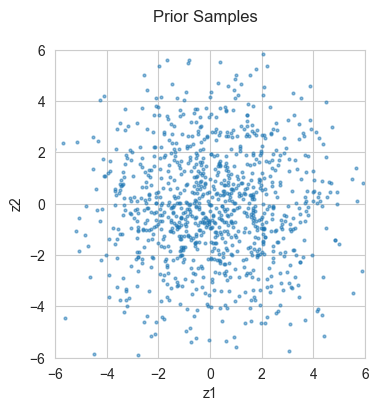

In [5]:
# Visualize samples from the prior.
with pyro.plate("prior_viz", 1000):
    prior_samples = prior()

plt.figure(figsize=(4, 4))
plt.scatter(prior_samples[0].detach().numpy(), prior_samples[1].detach().numpy(), alpha=0.5, s=4.)
plt.xlabel("z1")
plt.ylabel("z2")
plt.suptitle("Prior Samples")

LIMS = (-6., 6.)
plt.xlim(*LIMS)
plt.ylim(*LIMS)

In [6]:
class FullModel(torch.nn.Module):
    def __init__(self, prior: torch.nn.Module, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prior = prior
        self.noise = torch.tensor(0.5)
        
    def forward(self, n=1):
        ps = self.prior()  # prior sample
        
        # TODO make the normal prior just use a dict and not a tuple.
        #  The issue is that the tuple return makes it hard to use a
        #  guide in place of the prior, which returns a dict by default.
        if isinstance(ps, dict):
            z1, z2 = ps["z1"], ps["z2"]
        elif isinstance(ps, tuple):
            z1, z2 = ps
        else:
            raise NotImplementedError(f"Unknown prior sample type: {type(ps)}")
        
        with pyro.plate("data", n, dim=-1):
            x = pyro.sample("x", dist.Normal(z1 + z2, self.noise))
    
        return x
model = FullModel(prior)

# Data Generation

In [7]:
true_latents = dict(
    z1=tnsr([1.]),
    z2=tnsr([-3.])
)

In [8]:
N = 100
observed_data = dict(x=condition(partial(model, n=N), data=true_latents)())

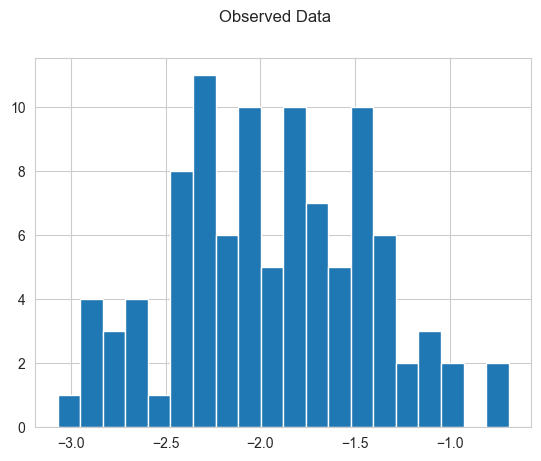

In [9]:
plt.hist(observed_data["x"].detach().numpy(), bins=20)
plt.suptitle("Observed Data")
pass

In [10]:
conditioned_model = condition(partial(model, n=N), data=observed_data)

# Inference

In [11]:
# During this initial SVI, we don't want to optimize with respect to the prior parameters, so disable gradients for them.
for param in prior.parameters():
    param.requires_grad_(False)

In [12]:
svi = build_svi_iter(
    model=conditioned_model,
    lr=1e-3,
    
    variational_family=AutoMultivariateNormal,
    init_scale=4.0,
    
    # variational_family=AutoDelta,
    
    # variational_family=ZukoGuide,
    # features=2,
    # context=0,
    # transforms=1,
    # hidden_features=(4, 4)
)

In [13]:
# # DEBUG
# for param in prior.parameters():
#     param.requires_grad_(True)

In [14]:
# # DEBUG
# {k: v.grad for k, v in prior.named_parameters()}

In [15]:
# # DEBUG
# for p in svi.guide.parameters():
#     p.grad = None
# for p in prior.parameters():
#     p.grad = None

In [16]:
# # DEBUG
# svi.svi_iter(step_optimizer=False, detach_losses_override=False).backward()

In [17]:
# # Function to list all leaf tensors that require gradients
# def find_leaf_tensors(tensor):
#     leaf_tensors = set()
# 
#     def add_leaf(tensor):
#         if tensor.is_leaf and tensor.requires_grad:
#             leaf_tensors.add(tensor)
# 
#     # Traverse the graph from the output tensor
#     torch.autograd._functions.traverse_map(tensor.grad_fn, add_leaf)
#     
#     return list(leaf_tensors)
# 
# # Get the leaf tensors
# leaf_tensors = find_leaf_tensors(svi.svi_iter(step_optimizer=False, detach_losses_override=False))
# 
# # Print out the leaf tensors
# for tensor in leaf_tensors:
#     print(tensor.shape)

In [18]:
# # DEBUG
# {k: v.grad for k, v in prior.named_parameters()}

In [19]:
# # DEBUG
# for param in prior.parameters():
#     param.requires_grad_(False)

In [20]:
NITER = 15000
# NITER = 1000  # DEBUG
for _ in range(NITER):
    print(f"Progress {_}/{NITER}", end="\r")
    svi.svi_iter()

In [21]:
# DEBUG
[p.grad for p in prior.parameters()]

[None, None]

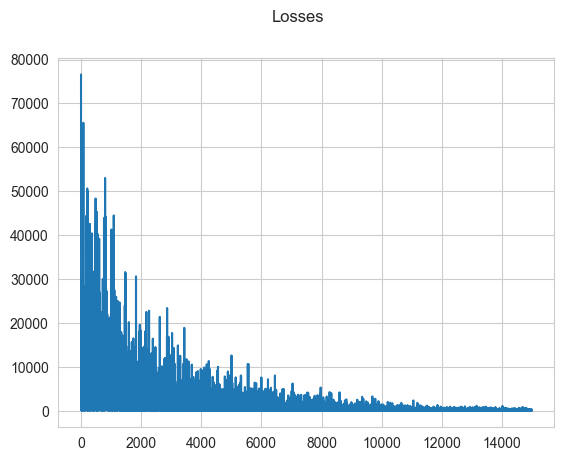

In [22]:
plt.plot(svi.losses)
plt.suptitle("Losses")
pass

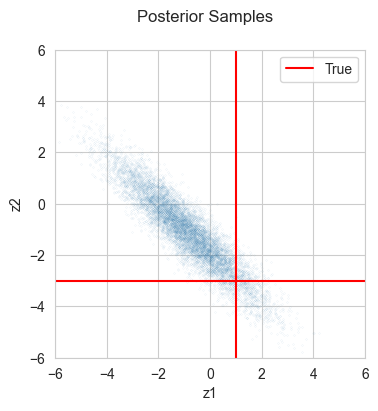

In [23]:
# Plot posterior samples.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = svi.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.suptitle("Posterior Samples")
plt.xlim(*LIMS)
plt.ylim(*LIMS)
pass

# Functional
We're interested in the sum of `z1` and `z2`, but where we intervene to set `z2=0`.  

In [24]:
class IntervenedSum(torch.nn.Module):
    
    def __init__(self, model, z2value, num_monte_carlo, reshaper=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.z2value = z2value
        self.num_monte_carlo = num_monte_carlo
        self.reshaper = reshaper or (lambda x: x)
        
    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
            with do(actions=dict(z2=self.z2value)):
                x = self.model(*args, **kwargs)
                return self.reshaper(x)

In [25]:
functional = IntervenedSum(PredictiveModel(model, svi.guide), z2value=tnsr([0.]), num_monte_carlo=50000, reshaper=torch.mean)

In [26]:
# Failure to capture the true answer due to non-identification (true answer is 1.).
functional()

tensor(-0.8668, grad_fn=<MeanBackward0>)

# Posterior Sensitivity

In [27]:
# Generate a grid of z1, z2 value pairs to assess sensitivity wrt.
GRID_RES = 300
z1_values = torch.linspace(*LIMS, GRID_RES)
z2_values = torch.linspace(*LIMS, GRID_RES)
z1_grid, z2_grid = torch.meshgrid(z1_values, z2_values, indexing='ij')

# And flatten into something we can pass to the influence function computation.
points = dict(z1=z1_grid.reshape(-1), z2=z2_grid.reshape(-1))

In [28]:
class IntervenedSum_FunctionalOfGuide(IntervenedSum):
    def __init__(self, guide, model, *args, **kwargs):
        super().__init__(PredictiveModel(model, guide), *args, **kwargs)

In [29]:
partial_funcofguide = partial(
    IntervenedSum_FunctionalOfGuide,
    model=model,
    z2value=tnsr([0.]),
    num_monte_carlo=3000,
    reshaper=torch.mean
)

In [30]:
partial_funcofguide(svi.guide)()

tensor(-0.8643, grad_fn=<MeanBackward0>)

In [31]:
# HACK for now, because I couldn't figure out how to reliably get log probabilities out of an auto-guide or zuko guide.
class ManualLogProbComputer(torch.nn.Module):
    def __init__(self, guide):
        super().__init__()
        self.guide = guide
        
    def forward(self, points):
        stacked_points = torch.hstack((points["z1"][:, None], points["z2"][:, None]))
        posterior_dist = self.guide.get_posterior()
        return posterior_dist.log_prob(stacked_points)

In [32]:
with torch.no_grad():
    compute_posterior_inf_on_posterior_pred = full_linearize_from_left(
        svi.guide,
        functional=partial_funcofguide,
        num_samples_outer=int(3e3),  # number of samples used to estimate empirical fisher.
        num_samples_inner=1,  # not used for this b/c no marginalization required.
        points_omit_latent_sites=False,  # no marginalization of latents is required.
        # The parameter paths in the svi.guide module and functional differ, despite
        #  pointing to the same parameters. This option will try to remap matching
        #  parameters to have the same path.
        remap_parameter_paths=True,
        log_prob_computer=ManualLogProbComputer,
        predictive_sites=("z1", "z2"),
    )

In [33]:
# DEBUG
list(type(p) for p in svi.guide.parameters())
# So these don't result in the module's parameters being wrapped in functional tensors...even though we make_functional_call and jacrev it... See way below note 27fuh186ydfj0

[torch.nn.parameter.Parameter,
 torch.nn.parameter.Parameter,
 torch.nn.parameter.Parameter]

In [34]:
import time
few_points = {k: v for k, v in points.items()}
with torch.no_grad():
    s = time.time()
    posterior_inf_on_posterior_pred = compute_posterior_inf_on_posterior_pred(few_points)
    print("Elapsed:", time.time() - s)
    print(posterior_inf_on_posterior_pred.shape)

Elapsed: 0.005651950836181641
torch.Size([90000])


In [35]:
# # DEBUG
# list(svi.guide.parameters())

### Visualize Posterior Sensitivity
The target functional is `E[x|D, do(z2=0)]`, where `x=z1+z2`. We estimate this with a variational approximation to the posterior over `z1` and `z2` conditioned on observations of their sum. Because `z2` is being forcibly set to zero here, the influence on the posterior expectation of `x` should be entirely the purview of `z1`. Indeed, we see that, only by adding probability mass to the right of the posterior mean of `z1`, will the target functional increase. By adding mass to the left, the target functional will decrease.

Text(0.5, 0.98, 'Functional Sensitivity to Posterior Perturbations')

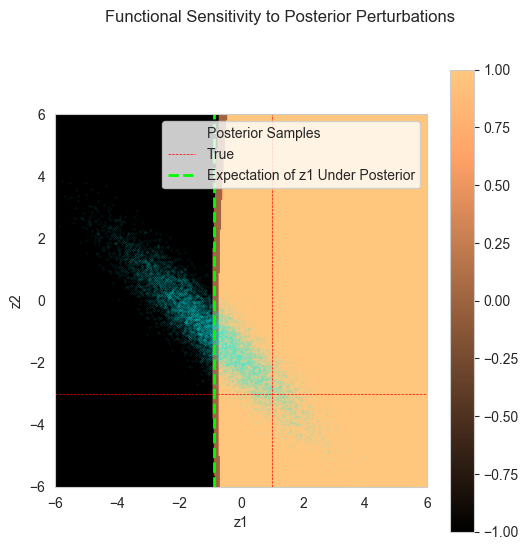

In [36]:
# Reshape the posterior_inf_on_posterior_pred to be used as the color
#  of our meshgrid plot.
posterior_inf_on_posterior_pred_grid = posterior_inf_on_posterior_pred.reshape(GRID_RES, GRID_RES)

# Plot the sensitivity of the posterior predictive to the posterior
#  distribution of the latent variables.
plt.figure(figsize=(6, 6))

# plt.imshow(
#     posterior_inf_on_posterior_pred_grid.T,
#     extent=(*LIMS, *LIMS), origin='lower',
#     cmap="copper"
# )

# Plot something a little more interpretable. We want to set -1 where < 0, 1 where > 0, and then keep 0 for isclose to zero for that contour.
simple_post_inf = posterior_inf_on_posterior_pred_grid.clone()
simple_post_inf[simple_post_inf < 0] = torch.tensor(-1.)
simple_post_inf[simple_post_inf > 0] = torch.tensor(1.)
simple_post_inf[torch.isclose(posterior_inf_on_posterior_pred_grid, torch.tensor(0.), atol=1e-1)] = torch.tensor(0.)
plt.imshow(
    simple_post_inf.T,
    extent=(*LIMS, *LIMS), origin='lower',
    cmap="copper"
)

plt.colorbar()
plt.xlabel("z1")
plt.ylabel("z2")

# Plot the truth and a low-alpha posterior scatter.
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=0.5, s=0.01, color="cyan", label="Posterior Samples")
plt.axvline(true_latents["z1"].item(), color="red", label="True", linewidth=0.5, linestyle="--")
plt.axhline(true_latents["z2"].item(), color="red", linewidth=0.5, linestyle="--")

# Force lims.
plt.xlim(*LIMS)
plt.ylim(*LIMS)

# Show the axvline for the functional's estimate under the current posterior.
plt.axvline(partial_funcofguide(svi.guide)().detach(), color="lime", label="Expectation of z1 Under Posterior", linewidth=2.0, linestyle="--")

# Remove grid lines.
plt.grid(False)

plt.legend()
plt.suptitle("Functional Sensitivity to Posterior Perturbations")

# Prior Sensitivity
We defined the earlier functional with respect to a posterior approximation. This meant we could merely slot that approximation in, in place of the prior, and compute the functional. Now, however, we want to rewrite the functional with respect to the prior, which is unfortunately obscured behind the posterior approximation, which is itself a functional of the prior that involves inference. To resolve this, we will use importance sampling in "reparametrization", of sorts, where inference still aids in our estimation, but where the functional can be written with respect to the prior more directly.

To do so, we'll use the single stage TABI decomposition, which involves adding a log factor for the quantity you wish to take the expectation with respect to.

In [37]:
partial_functional = partial(
    IntervenedSum,
    z2value=tnsr([0.]),
    num_monte_carlo=1000,
    reshaper=torch.mean
)

In [38]:
functional_of_prior_estimator = TABIReparametrizedFunctionalOfPrior(
    prior=prior,
    full_model_functional_of_prior=FullModel,
    data=observed_data,
    functional=partial_functional,
    num_monte_carlo=min(1000, NITER)
)

In [39]:
functional_of_prior_estimator.build_svi_iters(
    lr=5e-4,
    # variational_family=AutoMultivariateNormal,
    # init_scale=4.0
    
    variational_family=ZukoGuide,
    features=2,
    context=0,
    transforms=1,
    hidden_features=(4, 4)
)

In [40]:
# DEBUG testing just the posterior part.
# NITER = 20000
NITER = 1000  # DEBUG

for i in range(NITER):
    functional_of_prior_estimator.den_comp_svi_iter.svi_iter(
        retain_graph=False
    )
    print(f"Progress {i}/{NITER}", end="\r")

In [41]:
@singledispatch
def strip_for_plotting(_):
    raise NotImplementedError()

@strip_for_plotting.register(list)
def _(x):
    return [strip_for_plotting(v) for v in x]

@strip_for_plotting.register(torch.Tensor)
def _(x):
    return x.detach().numpy()

@strip_for_plotting.register(float)
def _(x):
    return x

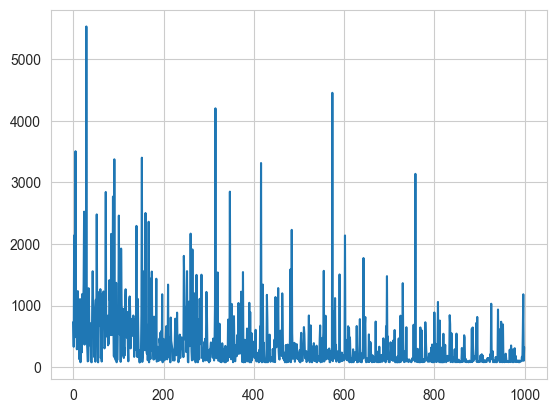

In [42]:
# DEBUG vis
plt.plot(
    strip_for_plotting(functional_of_prior_estimator.den_comp_svi_iter.losses)
)

(-6.0, 6.0)

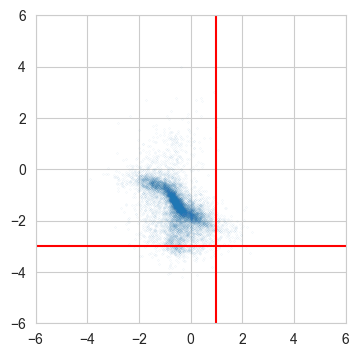

In [43]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.den_comp_svi_iter.guide()

plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)


In [44]:
# DEBUG do the same thing but for the positive component pos_comp_svi_iter
for i in range(NITER):
    functional_of_prior_estimator.pos_comp_svi_iter.svi_iter(retain_graph=False)
    print(f"Progress {i}/{NITER}", end="\r")


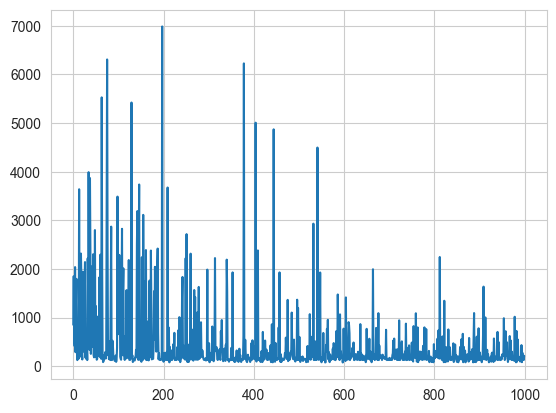

In [45]:
# DEBUG vis
plt.plot(
    strip_for_plotting(functional_of_prior_estimator.pos_comp_svi_iter.losses)
)

(-6.0, 6.0)

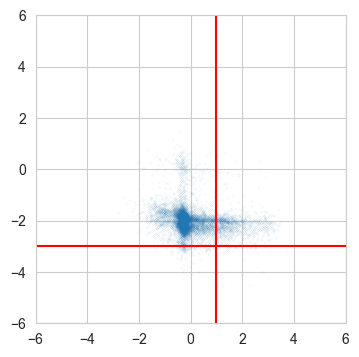

In [46]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.pos_comp_svi_iter.guide()

plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)


In [47]:
# And for neg_comp_svi_iter
for i in range(NITER):
    functional_of_prior_estimator.neg_comp_svi_iter.svi_iter(retain_graph=False)
    print(f"Progress {i}/{NITER}", end="\r")

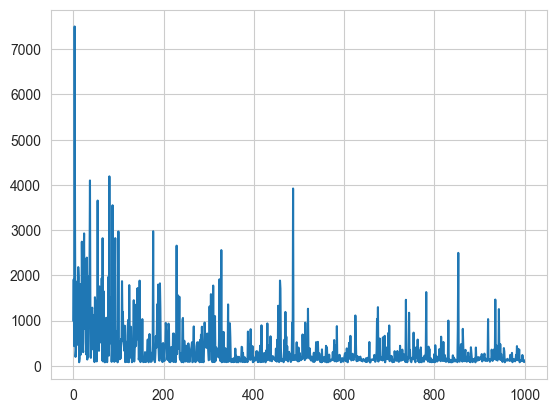

In [48]:
# DEBUG vis
plt.plot(strip_for_plotting(functional_of_prior_estimator.neg_comp_svi_iter.losses))

(-6.0, 6.0)

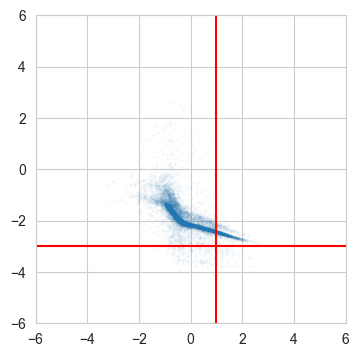

In [49]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.neg_comp_svi_iter.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)

In [50]:
# DEBUG
# real eif mode should only show prior parameters as requiring grad.
with functional_of_prior_estimator.in_eif_mode() as f:
    print({
        k: v.requires_grad for k, v in f.named_parameters()
    })

{'prior.loc': True, 'prior.scale_tril': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.0.weight': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.0.bias': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.2.weight': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.2.bias': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.4.weight': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.4.bias': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.0.weight': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.0.bias': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.2.weight': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.2.bias': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.4.weight': False, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.4.bias': False, 'den_comp_guide.flow.transform

In [51]:
# DEBUG
# Fake EIF mode should have prior params not requiring grad and guide params requiring grad.
functional_of_prior_estimator._is_in_eif_mode = True
print({
    k: v.requires_grad for k, v in functional_of_prior_estimator.named_parameters()
})
functional_of_prior_estimator._is_in_eif_mode = False

{'prior.loc': False, 'prior.scale_tril': False, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.0.weight': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.0.bias': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.2.weight': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.2.bias': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.4.weight': True, 'pos_comp_guide.flow.transform.transform.transforms.0.hyper.4.bias': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.0.weight': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.0.bias': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.2.weight': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.2.bias': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.4.weight': True, 'neg_comp_guide.flow.transform.transform.transforms.0.hyper.4.bias': True, 'den_comp_guide.flow.transform.transform

In [52]:
# Restore gradients for prior parameters, as we now want to take grads with respect to those parameters.
# TODO so before we had to enable this before svi so that the grads were attached, but I think it might be fixed now that we moved the intermediate compute to the forward of the prior? I.e. we only have to reenable for backwarding the loss, and otherwise we're good?
# TODO oh this might be because we're re-computing the elbo loss without backwarding in the functional forward now...
for param in prior.parameters():
    param.requires_grad_(True)

In [53]:
# DEBUG try in eif mode.
with functional_of_prior_estimator.in_eif_mode() as f:
    print("forward", f())

forward tensor(-0.5820, grad_fn=<SubBackward0>)


In [54]:
# # DEBUG
# with functional_of_prior_estimator.in_eif_mode():
#     print(dict(
#         functional_of_prior_estimator.den_comp.named_parameters()
#     ))
#     
#     # functional_of_prior_estimator.den_comp()
#     # 
#     with pyro.poutine.trace() as tr:
#         functional_of_prior_estimator.den_comp()
#     tr.get_trace().log_prob_sum().backward(retain_graph=False)

AttributeError: 'FunctionalFactorAdded' object has no attribute 'named_parameters'

In [ ]:
# # DEBUG
# {k: v.grad for k, v in prior.named_parameters()}

In [ ]:
# # DEBUG
# for p in prior.parameters():
#     p.grad = None

In [ ]:
# # DEBUG make a functional call of the den_comp log prob, just to see if it happens there.
# class FunctionalFactorLogProb(torch.nn.Module):
#     def __init__(self, func_fac_add):
#         super().__init__()
#         self.func_fac_add = func_fac_add
#     
#     def forward(self):
#         with pyro.poutine.trace() as tr:
#             self.func_fac_add()
#         return tr.get_trace().log_prob_sum()

In [ ]:
# # DEBUG
# from chirho.robust.internals.utils import make_functional_call
# den_comp_params, den_comp_func = make_functional_call(FunctionalFactorLogProb(functional_of_prior_estimator.den_comp))

In [ ]:
# den_comp_params

In [ ]:
# # DEBUG CULPRIT — this one breaks! and does wrap the parameters in place.
# # Note that this isn't even a jac...
# den_comp_func(den_comp_params)

In [ ]:
# dict(prior.named_parameters())

In [55]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [56]:
from chirho.robust.internals.utils import make_functional_call

with functional_of_prior_estimator.in_eif_mode() as f:
    prior_params, pure_functional_of_prior = make_functional_call(f)

In [57]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [58]:
prior_params

{'prior.loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'prior.scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [59]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), prior_params.values())}

{'loc': True, 'scale_tril': True}

In [ ]:
# # FIXME backwarding the functional call results in the prior.parameters being wrapped in FunctionalTensors in place. Which of course breaks many things that expect them to be Parameters.
# with functional_of_prior_estimator.in_eif_mode() as f:
#     print(pure_functional_of_prior(prior_params).backward(retain_graph=True))

In [ ]:
# # DEBUG
# {k: v.grad for k, v in prior.named_parameters()}

In [ ]:
# # DEBUG
# {k: v.grad for k, v in prior_params.items()}

In [ ]:
# dict(prior.named_parameters())

In [ ]:
# prior_params

In [ ]:
# {k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), prior_params.values())}

In [60]:
with functional_of_prior_estimator.in_eif_mode():
    pure_functional_of_prior_jac_fn = torch.func.jacrev(pure_functional_of_prior)

In [61]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [62]:
prior_params

{'prior.loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'prior.scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [63]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), prior_params.values())}

{'loc': True, 'scale_tril': True}

In [64]:
# DEBUG CULPRIT — this one breaks! and does wrap the parameters in place.
# NOTES:
# So unlike the others, this is actually resetting the prior params a bunch of times to the functionaltensor (gradchecking tensor) wrapped thing, and then at the end it doesn't restore them to the original unwrapped parameter versions.
# The others set the wrappers a single time, and then restore at the end.
# This resets them 17 times each for some reason?
with functional_of_prior_estimator.in_eif_mode():
    print(pure_functional_of_prior_jac_fn(prior_params))

OLD VALUE: Parameter containing:
tensor([0., 0.], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([0., 0.], requires_grad=True)
))
OLD VALUE: Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([[2.2361, 0.0000],
            [-0.0000, 2.2361]], requires_grad=True)
))
Setting parameter for argument loc
Setting parameter for argument scale_tril
{'prior.loc': tensor([ 0.2172, -0.2218], grad_fn=<ViewBackward0>), 'prior.scale_tril': tensor([[-0.1002, -0.0843],
        [-0.0843,  0.2769]], grad_fn=<ViewBackward0>)}


In [65]:
with functional_of_prior_estimator.in_eif_mode() as f:
    print(len([p for p in f.parameters() if p.requires_grad]))

2


In [ ]:

# Cont 27fuh186ydfj0: But here, after making a functional call of the forward, we DO end up with our module's parameters wrapped in place by FunctionalTensors...and also converted to GradCheckingTensors??

In [66]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [67]:
prior.loc

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [68]:
prior.scale_tril

Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True)

In [69]:
prior_params

{'prior.loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'prior.scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [70]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), prior_params.values())}

{'loc': True, 'scale_tril': True}

In [71]:
from chirho.robust.internals.full_linearize_from_left import ExactLogProb
from chirho.robust.internals.utils import make_functional_call
exact_prior_log_prob = ExactLogProb(prior)
log_prob_params, func_log_prob = make_functional_call(exact_prior_log_prob, ignore_params_not_requiring_grad=True)

In [72]:
# Cont 27fuh186ydfj0: which then results in requires_grad being false for these "parameters" cz the wrappers don't actually require grad themselves...
log_prob_params

{'model.loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'model.scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [73]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), log_prob_params.values())}

{'loc': True, 'scale_tril': True}

In [74]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [75]:
log_prob_jac_fn = torch.func.jacrev(func_log_prob)

In [76]:
# DEBUG CULPRIT — this one is also fine, it doesn't wrap the parameters in place!
log_prob_jac_fn(log_prob_params, {k: v[:100] for k, v in points.items()})

OLD VALUE: Parameter containing:
tensor([0., 0.], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([0., 0.], requires_grad=True)
))
OLD VALUE: Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([[2.2361, 0.0000],
            [-0.0000, 2.2361]], requires_grad=True)
))
Setting parameter for argument loc
Setting parameter for argument scale_tril


{'model.loc': tensor([[-1.2000, -1.2000],
         [-1.2000, -1.1920],
         [-1.2000, -1.1839],
         [-1.2000, -1.1759],
         [-1.2000, -1.1679],
         [-1.2000, -1.1599],
         [-1.2000, -1.1518],
         [-1.2000, -1.1438],
         [-1.2000, -1.1358],
         [-1.2000, -1.1278],
         [-1.2000, -1.1197],
         [-1.2000, -1.1117],
         [-1.2000, -1.1037],
         [-1.2000, -1.0957],
         [-1.2000, -1.0876],
         [-1.2000, -1.0796],
         [-1.2000, -1.0716],
         [-1.2000, -1.0635],
         [-1.2000, -1.0555],
         [-1.2000, -1.0475],
         [-1.2000, -1.0395],
         [-1.2000, -1.0314],
         [-1.2000, -1.0234],
         [-1.2000, -1.0154],
         [-1.2000, -1.0074],
         [-1.2000, -0.9993],
         [-1.2000, -0.9913],
         [-1.2000, -0.9833],
         [-1.2000, -0.9753],
         [-1.2000, -0.9672],
         [-1.2000, -0.9592],
         [-1.2000, -0.9512],
         [-1.2000, -0.9431],
         [-1.2000, -0.9351],
 

In [77]:
# Cont 27fuh186ydfj0: which then results in requires_grad being false for these "parameters" cz the wrappers don't actually require grad themselves...
log_prob_params

{'model.loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'model.scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [78]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), log_prob_params.values())}

{'loc': True, 'scale_tril': True}

In [79]:
dict(prior.named_parameters())

{'loc': Parameter containing:
 tensor([0., 0.], requires_grad=True),
 'scale_tril': Parameter containing:
 tensor([[2.2361, 0.0000],
         [-0.0000, 2.2361]], requires_grad=True)}

In [80]:
test_prior_params, test_prior_func = make_functional_call(prior)

In [81]:
test_prior_func(test_prior_params)

OLD VALUE: Parameter containing:
tensor([0., 0.], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=1, value=\
Parameter containing:
tensor([0., 0.], requires_grad=True))
OLD VALUE: Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=1, value=\
Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True))
Setting parameter for argument loc
Setting parameter for argument scale_tril


(tensor(1.8422, grad_fn=<AddBackward0>),
 tensor(2.7095, grad_fn=<AddBackward0>))

In [82]:
test_prior_jac_fn = torch.func.jacrev(test_prior_func)

In [83]:
# DEBUG CULPRIT — this one is fine, it doesn't wrap the parameters in place.
test_prior_jac_fn(test_prior_params)

OLD VALUE: Parameter containing:
tensor([0., 0.], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([0., 0.], requires_grad=True)
))
OLD VALUE: Parameter containing:
tensor([[2.2361, 0.0000],
        [-0.0000, 2.2361]], requires_grad=True)
NEW VALUE: FunctionalTensor(lvl=2, value=\
GradTrackingTensor(lvl=1, value=
    Parameter containing:
    tensor([[2.2361, 0.0000],
            [-0.0000, 2.2361]], requires_grad=True)
))
Setting parameter for argument loc
Setting parameter for argument scale_tril


({'loc': tensor([1., 0.], grad_fn=<ViewBackward0>),
  'scale_tril': tensor([[-0.3425,  0.0000],
          [ 0.0000,  0.0000]], grad_fn=<ViewBackward0>)},
 {'loc': tensor([0., 1.], grad_fn=<ViewBackward0>),
  'scale_tril': tensor([[ 0.0000, -0.3425],
          [-0.3425, -1.7763]], grad_fn=<ViewBackward0>)})

In [84]:
{k: v1 is v2 for (k, v1), v2 in zip(prior.named_parameters(), test_prior_params.values())}

{'loc': True, 'scale_tril': True}